In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import os

In [2]:
reference = np.zeros((100, 100))
reference[20:40, 20:40] = 200

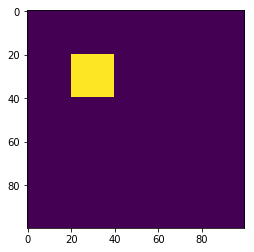

In [3]:
plt.imshow(reference)

In [4]:
moving = np.zeros_like(reference)
moving[50:70, 20:40] = 200

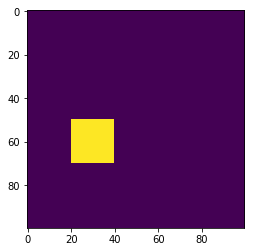

In [5]:
plt.imshow(moving)

In [25]:
a,b,tx,c,d,ty = 1,0,-10,0,1,10
matrix = [[a,b,tx], [c,d,ty], [0,0,1]]
inver_matrix = np.linalg.inv(matrix)
print(inver_matrix)
output = scipy.ndimage.affine_transform(input=moving, matrix=inver_matrix)

[[  1.   0.  10.]
 [  0.   1. -10.]
 [  0.   0.   1.]]


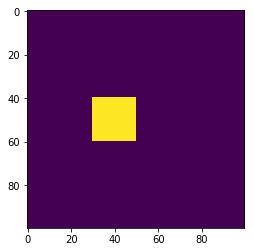

In [26]:
plt.imshow(output)

In [27]:
def cost(output, reference):
    return np.sum((output-reference)**2)

In [28]:
cost_1 = cost(output, reference)
print("cost is {}".format(cost_1))

cost is 32000000.000000007


In [29]:
def get_dc2de(output, reference):
    return np.abs(2 * (output - reference))

In [30]:
def get_de2dx(output, reference):
    dx = np.zeros_like(output)
    dout = np.zeros_like(output)
    drefe = np.zeros_like(output)
    dout[0:-1] = np.abs(output[1:] - output[0:-1])
    drefe[0:-1] = np.abs(reference[1:] - reference[0:-1])
    dx = dout - drefe
#     dx[0:-1] = e[1:] - e[0:-1]
#     plt.imshow(dx)
    dx_mean = np.mean(dx, axis=1).reshape(output.shape[0], 1)
    dx = np.ones_like(output) * dx_mean
    return dx

In [31]:
def get_de2dy(output, reference):
    dy = np.zeros_like(output)
    dout = np.zeros_like(output)
    drefe = np.zeros_like(output)
    dout[:,0:-1] = np.abs(output[:,1:] - output[:,0:-1])
    drefe[:,0:-1] = np.abs(reference[:,1:] - reference[:,0:-1])
    dy = dout - drefe
#     plt.imshow(dy)
    dy_mean = np.mean(dy, axis=0).reshape(1, output.shape[1])
    dy = np.ones_like(output) * dy_mean
    return dy

In [32]:
def buildMatrix(output, matrix):
    len_x, len_y = output.shape
    matrix_ = np.asarray(np.meshgrid(np.arange(len_x), np.arange(len_y), indexing = 'ij'))
    matrix_ = np.rollaxis(matrix_, 0, 3)
    matrix_ = np.concatenate((matrix_[:,:,0].reshape([len_x,len_y,1]), matrix_[:,:,1].reshape([len_x,len_y,1]), np.ones([len_x, len_y, 1])), axis = 2)
    inverse = np.linalg.inv(matrix)
    new_matrix = np.dot(matrix_, inverse.T)
    new_matrix[new_matrix < 0] = 0
#     print(new_matrix.shape)
#     print(new_matrix[3,4,:])
    return new_matrix
    #new_matrix [i, j, _]

In [33]:
# x = a * i + b * j + tx
def get_dx2da(output, matrix):
    return buildMatrix(output, matrix)[:,:,0] / 1000
def get_dx2db(output, matrix):
    return buildMatrix(output, matrix)[:,:,1] /1000
def get_dx2dtx():
    return 1;

In [34]:
# y = c * i + d * j + ty
def get_dy2dc(output, matrix):
    return buildMatrix(output, matrix)[:,:,0] / 1000
def get_dy2dd(output, matrix):
    return buildMatrix(output, matrix)[:,:,1] / 1000
def get_dy2dty():
    return 1;

In [35]:
def get_dc2da(output, reference, matrix):
    return np.sum(get_dc2de(output=output, reference=reference) * get_de2dx(output=output, reference=reference) * get_dx2da(output=output, matrix=matrix)) \
        / (output.shape[0] * output.shape[1])
def get_dc2db(output, reference, matrix):
    return np.sum(get_dc2de(output=output, reference=reference) * get_de2dx(output=output, reference=reference) * get_dx2db(output=output, matrix=matrix)) \
        / (output.shape[0] * output.shape[1])
def get_dc2dtx(output, reference):
    return np.sum(get_dc2de(output=output, reference=reference) * get_de2dx(output=output, reference=reference) * get_dx2dtx()) \
        / (output.shape[0] * output.shape[1])
def get_dc2dc(output, reference, matrix):
    return np.sum(get_dc2de(output=output, reference=reference) * get_de2dy(output=output, reference=reference) * get_dy2dc(output=output, matrix=matrix)) \
        / (output.shape[0] * output.shape[1])
def get_dc2dd(output, reference, matrix):
    return np.sum(get_dc2de(output=output, reference=reference) * get_de2dy(output=output, reference=reference) * get_dy2dd(output=output, matrix=matrix)) \
        / (output.shape[0] * output.shape[1])
def get_dc2dty(output, reference):
    return np.sum(get_dc2de(output=output, reference=reference) * get_de2dy(output=output, reference=reference) * get_dy2dty()) \
        / (output.shape[0] * output.shape[1])

In [36]:
def get_dmatrix(output, reference, matrix):
    da = get_dc2da(output, reference, matrix)
    db = get_dc2db(output, reference, matrix)
    dtx = get_dc2dtx(output, reference)
    dc = get_dc2dc(output, reference, matrix)
    dd = get_dc2dd(output, reference, matrix)
    dty = get_dc2dty(output, reference)
#     da = 0
#     db = 0
#     dc = 0
#     dd = 0
    dmatrix = [[da, db, dtx], [dc, dd, dty], [0,0,0]]
    return dmatrix

In [37]:
def get_sum_abs(array):
    return np.sum(np.abs(array))

In [38]:
get_sum_abs(get_dc2dty(output, reference))

1.4548596079575274e-13

In [39]:
get_dmatrix(output, reference, matrix)

[[2.20800000000001, 0.9440000000000044, 32.00000000000016],
 [7.876259586662822e-15, 4.0472514228895314e-15, 1.4548596079575274e-13],
 [0, 0, 0]]

In [40]:
get_dmatrix(output, reference, matrix)

[[2.20800000000001, 0.9440000000000044, 32.00000000000016],
 [7.876259586662822e-15, 4.0472514228895314e-15, 1.4548596079575274e-13],
 [0, 0, 0]]

In [41]:
def updateAffMatrix(output, reference, matrix, speed):
    dmatrix = get_dmatrix(output, reference, matrix)
    new_matrix = np.asarray(matrix) + speed * np.asarray(dmatrix)
    return new_matrix

0th iteration loss: is 32000000.000000007
[[2.20800000000001, 0.9440000000000044, 32.00000000000016], [7.876259586662822e-15, 4.0472514228895314e-15, 1.4548596079575274e-13], [0, 0, 0]]
100th iteration loss: is 29369501.753659744
[[3.379527874033725, 1.4257095199647998, 56.06847220283034], [0.8312705157670269, 0.35634973192474406, 16.46503243932579], [0, 0, 0]]
200th iteration loss: is 25990781.494896844
[[3.054685124080818, 1.2925477153351879, 51.52687839603933], [2.0252733030793912, 0.8035015060243446, 38.694365758762665], [0, 0, 0]]
300th iteration loss: is 21676448.994566623
[[3.3895861968136525, 1.5451461477511046, 59.0296243270344], [2.1360155133457024, 0.8043943000623636, 40.37569902244051], [0, 0, 0]]
400th iteration loss: is 16153692.215820547
[[3.552308221125213, 1.6658965844477411, 62.197285197972576], [2.4922922245608605, 0.9441882806616552, 45.83901486625011], [0, 0, 0]]
500th iteration loss: is 9379176.30344244
[[3.50401319417579, 1.686818400137053, 61.43144626632396], [2

D:\Anaconda2\envs\py3.6\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


2100th iteration loss: is 4183613.7710234867
[[-0.1362124335201868, 0.09323791505168165, 4.8139465787204765], [0.01098167481179027, -0.0805876428680239, 1.4608832672443866], [0, 0, 0]]
2200th iteration loss: is 4163855.4554141285
[[-0.13724006448651144, 0.09138320671261327, 4.737628373822494], [0.010954243891766687, -0.07876595089165306, 1.4702892148972888], [0, 0, 0]]
2300th iteration loss: is 4144115.7029241314
[[-0.13893874602970727, 0.08924191323174502, 4.660009886144417], [0.011229880068925276, -0.07701265260745008, 1.4814736954902448], [0, 0, 0]]
2400th iteration loss: is 4124303.6877123993
[[-0.13943198282730984, 0.08790395458864064, 4.607471500216424], [0.011887652643931304, -0.07508846688268841, 1.4980710692009978], [0, 0, 0]]
2500th iteration loss: is 4104533.7353335167
[[-0.13811821897850546, 0.08743815294733318, 4.583503963896641], [0.012134160245406443, -0.07334223462799296, 1.505136557896775], [0, 0, 0]]
2600th iteration loss: is 4084740.526446491
[[-0.13977497085980436, 

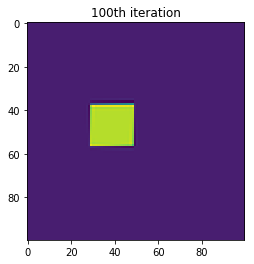

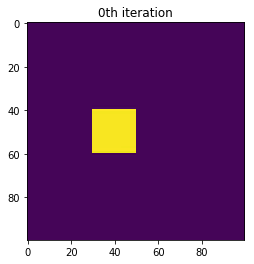

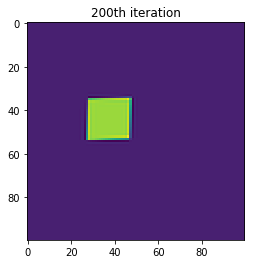

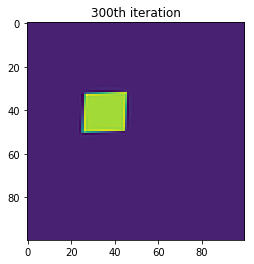

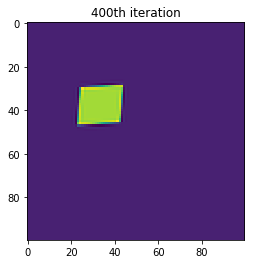

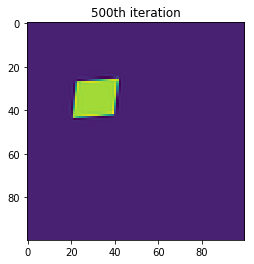

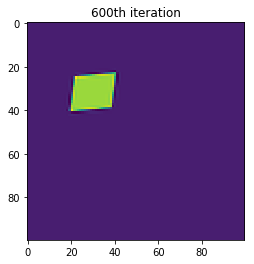

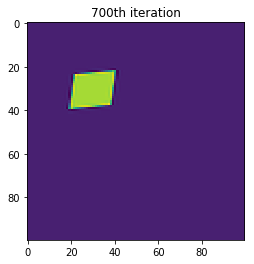

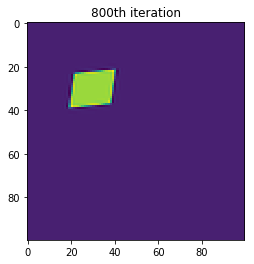

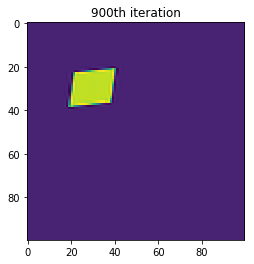

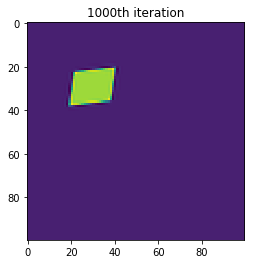

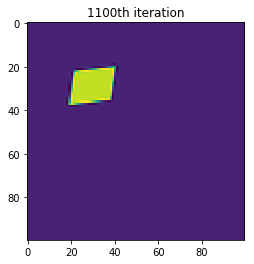

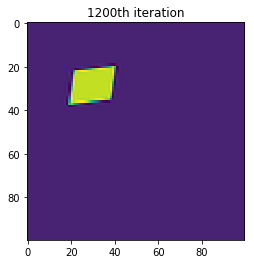

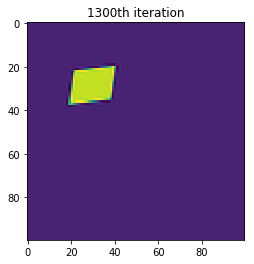

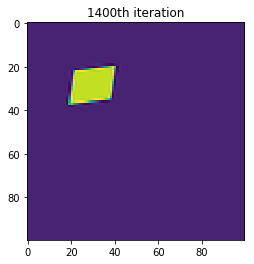

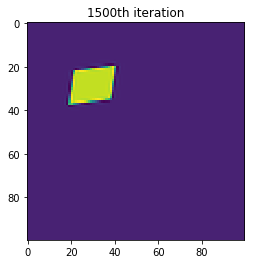

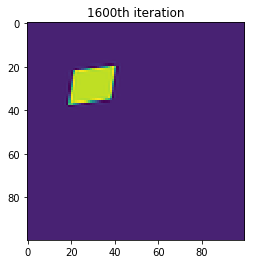

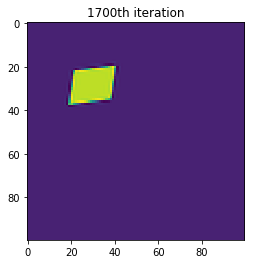

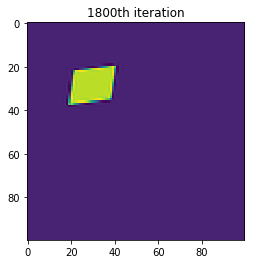

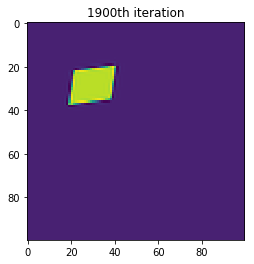

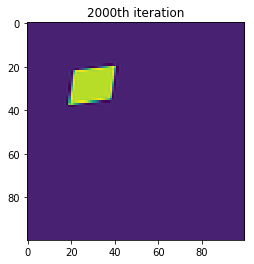

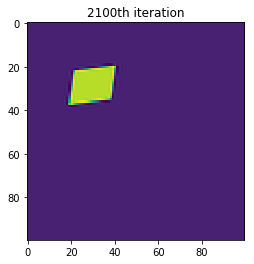

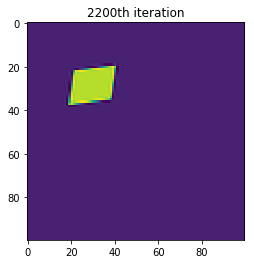

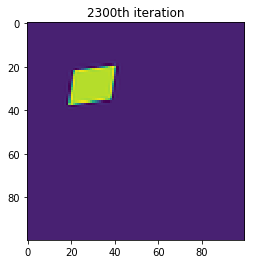

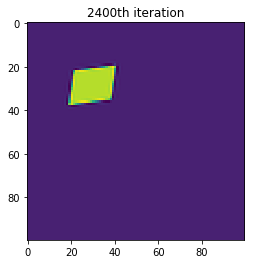

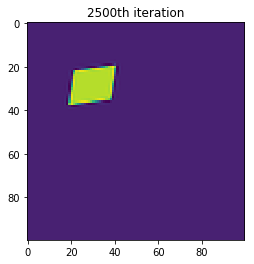

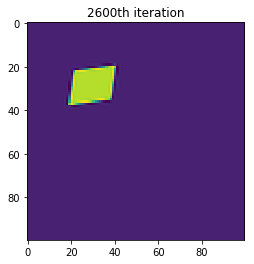

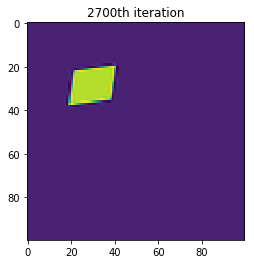

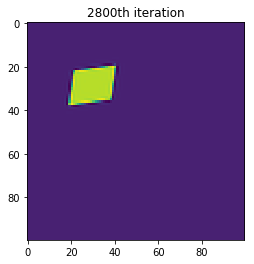

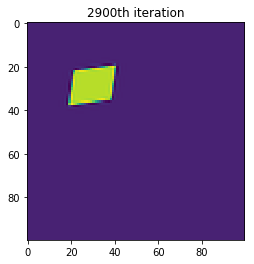

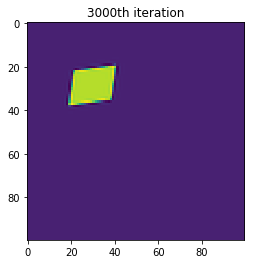

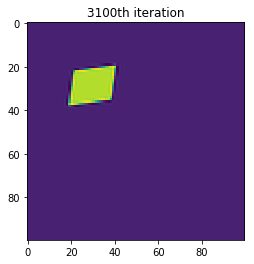

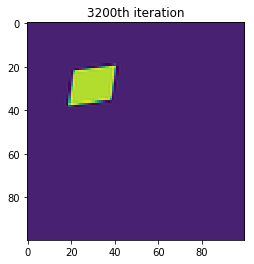

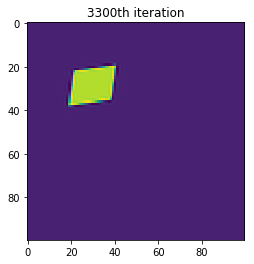

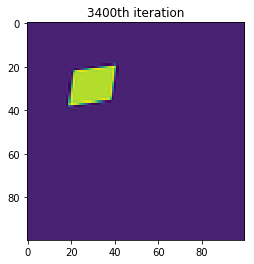

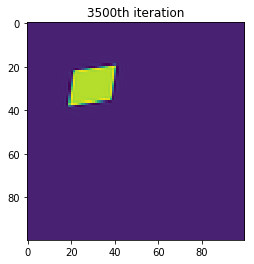

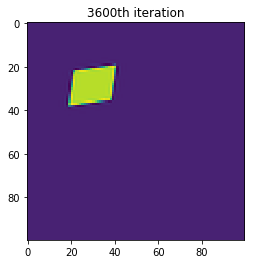

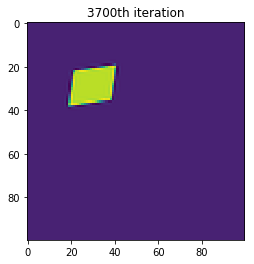

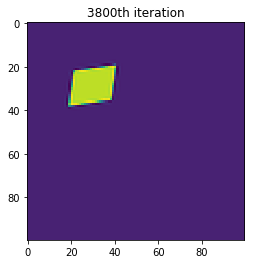

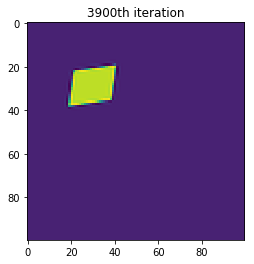

In [44]:
speed = 1e-4
iterate = 4000
n = 0
matrix = [[a,b,tx], [c,d,ty], [0,0,1]]
inver_matrix = np.linalg.inv(matrix)
output = scipy.ndimage.affine_transform(input=moving, matrix=inver_matrix)
plt.imshow(reference)
while  n < iterate:
    loss = np.sum(np.abs(output - reference) ** 2)
    dmatrix = get_dmatrix(output, reference, matrix)
    matrix = np.asarray(matrix) - speed * np.asarray(dmatrix)
    inver_matrix = np.linalg.inv(matrix)
    output = scipy.ndimage.affine_transform(input=moving, matrix=inver_matrix)
    if n % 100 == 0:
        print("{}th iteration loss: is {}".format(n, loss))
        print(dmatrix)
        plt.figure(n//100)
        plt.imshow(output)
        plt.title("{}th iteration".format(n))
    n = n+1


In [45]:
print(matrix)

[[  0.8135971   -0.13938807 -15.66554689]
 [ -0.11453383   0.98207944   7.38397335]
 [  0.           0.           1.        ]]
